# Binary Skin Segmentation

This notebook contains a tutorial on binary skin segmentation. You will learn:
* The fully convolutional architecture known as UNet for semantic segmentation
* How to implement UNet in MXNet symbolic API
* How to implement UNet in the Gluon interface
* How to train UNet in Amazon SageMaker, and deploy to an inference endpoint

# Setup

Import the following modules:

In [27]:
import mxnet as mx
from mxnet import ndarray as F
import numpy as np
import urllib
from PIL import Image
np.random.seed(1984)
import glob
import os
import urllib
import zipfile
from scipy.misc import imresize
from sklearn.cross_validation import train_test_split
import scipy.io as sio
from skimage import measure
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Data

The dataset in question exists in a git repository, so we're going to clone it locally.

In [2]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git /dev/shm/clothing-co-parsing

Cloning into 'clothing-co-parsing'...
remote: Counting objects: 4231, done.
remote: Total 4231 (delta 0), reused 0 (delta 0), pack-reused 4231
Receiving objects: 100% (4231/4231), 124.58 MiB | 66.86 MiB/s, done.
Resolving deltas: 100% (1098/1098), done.


Next, we load the names of the files containing the labels. For each image that has a label, we load that name.

In [2]:
image_dir = '/dev/shm/clothing-co-parsing/photos/'
label_files = glob.glob('/dev/shm/clothing-co-parsing/annotations/pixel-level/*.mat')
image_files = [os.path.join(image_dir, lf[-8:-4]+'.jpg') for lf in label_files]

Here we load the masks, and convert them into a binary format"
* The label for skin is pixel value 41, so we convert the multi-label masks into binary by checking for equality element-wise.
* The images are not the same resolution, so they are resized to a constant 820x550. Any interpolated label values greater than zero are set to one.
* MXNet requires the input to have dimension <tt>(batch, channel, height, width)</tt>, so these alterations are made.

In [3]:
X = []
Y = []
for i in range(len(image_files)):
    mask = (sio.loadmat(label_files[i])['groundtruth']==41).astype(np.uint8)
    mask = (imresize(mask, (820, 550)) > 0).astype(np.uint8)
    image = np.array(Image.open(image_files[i]).resize((550,820)))
    X.append(image)
    Y.append(mask)
X = np.transpose(np.stack(X), axes=(0, 3, 1, 2))
Y = np.expand_dims(np.stack(Y), 1)

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/scipy/misc/pilutil.py:554: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  im = toimage(arr, mode=mode)
/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/scipy/misc/pilutil.py:336: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  cmin=cmin, cmax=cmax)
/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/scipy/misc/pilutil.py:565: DeprecationWarning: `fromimage` is deprecated!
`fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
Use 

We have 1004 observations.

In [4]:
X.shape

(1004, 3, 820, 550)

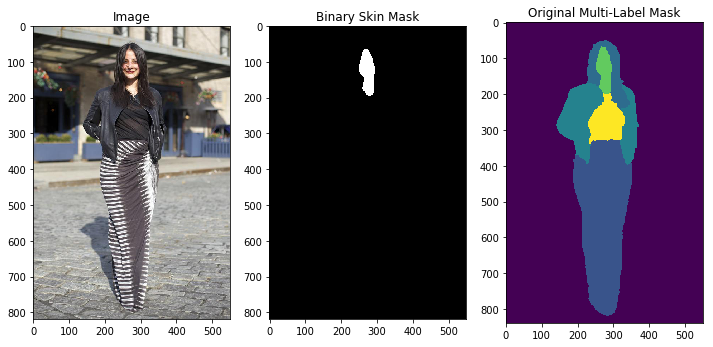

In [8]:
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.title('Image')
plt.imshow(np.transpose(X[100], axes=(1,2,0)))
plt.subplot(132)
plt.title('Binary Skin Mask')
plt.imshow(Y[100][0], cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Original Multi-Label Mask')
plt.imshow(sio.loadmat(label_files[100])['groundtruth'])

We're going to generate a new data-set through random cropping of our existing images. Before we do that, we need to split the data into training and validation data (if we did crops first, and then split, we run the risk of data leakage).

In [9]:
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, test_size=0.2, random_state=1984)

Segmentation networks tend to be computationally expensive, and therefore can't be feasibly trained on high-resolution images. However, because segmentation networks like UNet are **fully convolutional**, they can be trained on crops of larger images. The convolutional operation relies on **local** information only, and therefore by training on appropriate crops of a larger image, a model can be trained that works at full-resolution.

What defines an appropriate crop? We want our crops to always contain positives (to mitigate class imbalance), and we want to avoid literal edge cases where a crop captures only a small fraction of the positive region (such a crop would not contain the requisite local information expected to make valid predictions).

To that end, a good approach is to find **positive windows** in the input image; this is a region of the original image where **every crop** of a given size always contains a complete piece of the positive region. In other words, it's a region of the image centered (or approximately) on the positive region, such that any crop taken from that region completely contains the positive space.

By sampling only from these positive windows, both problems are handled:
* Every crop always contains a positive sample
* Every crop always contains a **complete** positive sample

Of course, by only sampling from these windows you're throwing out the information that can be gained from the negative space outside the window. To incorporate that space, you'd want to sample from it at a proportion that makes sense for your data set. We omit this step here.

In [10]:
def extract_positive_windows(x, shape=(256, 256)):
    props = measure.regionprops(measure.label(x))
    valid_boxes = []
    for prop in props:
        bb = prop.bbox
        valid_box = np.clip(np.array(bb) + np.array([-(shape[0]-1), -(shape[1]-1), (shape[0]-1), (shape[1]-1)]),
                            0, None)
        valid_box[2] = np.clip(valid_box[2], None, 819)
        valid_box[3] = np.clip(valid_box[3], None, 549)   
        valid_boxes.append(valid_box)
    return valid_boxes

In [11]:
def extract_boxes(X, Y, shape=(256, 256)):
    boxes = []
    for y in Y:
        boxes.append(extract_positive_windows(y, shape))
    X_boxes = []
    Y_boxes = []
    for i, x in enumerate(X):
        x_boxes = []
        y_boxes = []
        for box in boxes[i]:
            x_boxes.append(x[:,box[0]:box[2],box[1]:box[3]])
            y_boxes.append(Y[i,:,box[0]:box[2],box[1]:box[3]])
        X_boxes += x_boxes
        Y_boxes += y_boxes
    return X_boxes, Y_boxes

In [12]:
train_X_boxes, train_Y_boxes = extract_boxes(train_X, train_Y)
validation_X_boxes, validation_Y_boxes = extract_boxes(validation_X, validation_Y)

In [13]:
len(train_X_boxes)

3305

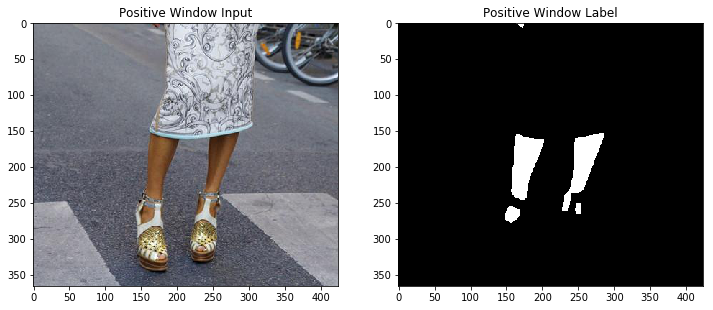

In [17]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Positive Window Input")
plt.imshow(np.transpose(train_X_boxes[100], axes=(1,2,0)))
plt.subplot(122)
plt.title("Positive Window Label")
plt.imshow(train_Y_boxes[100][0], cmap=plt.cm.gray)

Next, we generate the random crops.

In [18]:
def rand_crop(X, Y, shape):
    assert X.shape[1] > shape[0] and X.shape[2] > shape[1]
    delta_row = X.shape[1] - shape[0]
    delta_col = X.shape[2] - shape[1]
    start_row = np.random.randint(delta_row)
    start_col = np.random.randint(delta_col)
    return X[:, start_row:start_row+shape[0], start_col:start_col+shape[1]], Y[:, start_row:start_row+shape[0], start_col:start_col+shape[1]]

def generate_random_crops(X, Y, num_patches=10, crop_size=(256, 256)):
    X_crops = []
    Y_crops = []
    for i, x in enumerate(X):
        if x.shape[1] < crop_size[0] or x.shape[2] < crop_size[1]:
            continue
        for j in range(num_patches):
            x_crop, y_crop = rand_crop(x, Y[i], crop_size)
            if np.random.rand() > 0.5:
                x_crop = x_crop[:,:,::-1]
                y_crop = y_crop[:,:,::-1]
            X_crops.append(x_crop)
            Y_crops.append(y_crop)
    return np.stack(X_crops), np.stack(Y_crops)

In [19]:
train_X_crops, train_Y_crops = generate_random_crops(train_X_boxes, train_Y_boxes, num_patches=3)
validation_X_crops, validation_Y_crops = generate_random_crops(validation_X_boxes, validation_Y_boxes, num_patches=3)

In [20]:
train_X_crops.shape

(9915, 3, 256, 256)

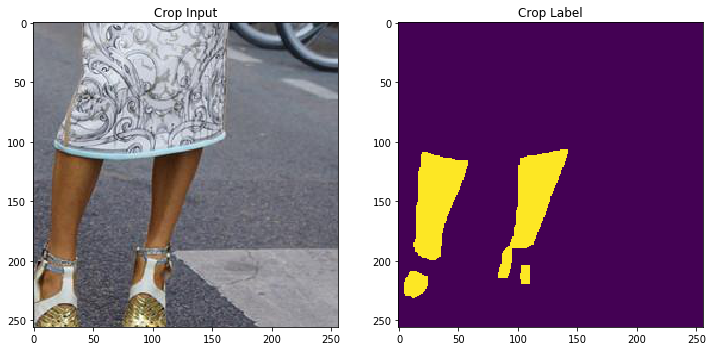

In [26]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Crop Input")
plt.imshow(np.transpose(train_X_crops[300], axes=(1,2,0)))
plt.subplot(122)
plt.title("Crop Label")
plt.imshow(train_Y_crops[300][0])

Next, we'll save the generated data locally so we can avoid generating again.

In [23]:
if not os.path.exists('/dev/shm/clothing-co-parsing/segmentation_data'): os.mkdir('/dev/shm/clothing-co-parsing/segmentation_data')
np.save('/dev/shm/clothing-co-parsing/segmentation_data/train_X_crops.npy', train_X_crops)
np.save('/dev/shm/clothing-co-parsing/segmentation_data/train_Y_crops.npy', train_Y_crops)
np.save('/dev/shm/clothing-co-parsing/segmentation_data/validation_X_crops.npy', validation_X_crops)
np.save('/dev/shm/clothing-co-parsing/segmentation_data/validation_Y_crops.npy', validation_Y_crops)

In [3]:
train_X_crops = np.load('/dev/shm/clothing-co-parsing/segmentation_data/train_X_crops.npy')
train_Y_crops = np.load('/dev/shm/clothing-co-parsing/segmentation_data/train_Y_crops.npy')
validation_X_crops = np.load('/dev/shm/clothing-co-parsing/segmentation_data/validation_X_crops.npy')
validation_Y_crops = np.load('/dev/shm/clothing-co-parsing/segmentation_data/validation_Y_crops.npy')

# Frameworks

We're going to proceed by defining the UNet Network for binary segmentation in both MXNet Symbolic API and the Gluon impertive interface.

## MXNet Symbolic

### Unet

Network architecture

In [23]:
def conv_block(inp, num_filter, kernel, pad, block, conv_block):
    conv = mx.sym.Convolution(inp, num_filter=num_filter, kernel=kernel, pad=pad, name='conv%i_%i' % (block, conv_block))
    conv = mx.sym.BatchNorm(conv, fix_gamma=True, name='bn%i_%i' % (block, conv_block))
    conv = mx.sym.Activation(conv, act_type='relu', name='relu%i_%i' % (block, conv_block))
    return conv

def down_block(inp, num_filter, kernel, pad, block, pool=True):
    conv = conv_block(inp, num_filter, kernel, pad, block, 1)
    conv = conv_block(conv, num_filter, kernel, pad, block, 2)
    if pool:
        pool = mx.sym.Pooling(conv, kernel=(2,2), stride=(2,2), pool_type='max', name='pool_%i' % block)
        return pool, conv
    return conv

def down_branch(inp):
    pool1, conv1 = down_block(inp, num_filter=32, kernel=(3,3), pad=(1,1), block=1)
    pool2, conv2 = down_block(pool1, num_filter=64, kernel=(3,3), pad=(1,1), block=2)
    pool3, conv3 = down_block(pool2, num_filter=128, kernel=(3,3), pad=(1,1), block=3)
    pool4, conv4 = down_block(pool3, num_filter=256, kernel=(3,3), pad=(1,1), block=4)
    conv5 = down_block(pool4, num_filter=512, kernel=(3,3), pad=(1,1), block=5, pool=False)
    return [conv5, conv4, conv3, conv2, conv1]

def up_block(inp, down_feature, num_filter, kernel, pad, block):
    trans_conv = mx.sym.Deconvolution(inp, num_filter=num_filter, kernel=(2,2), stride=(2,2), no_bias=True,
                                      name='trans_conv_%i' % block)
    up = mx.sym.concat(*[trans_conv, down_feature], dim=1, name='concat_%i' % block)
    conv = conv_block(up, num_filter, kernel, pad, block, 1)
    conv = conv_block(conv, num_filter, kernel, pad, block, 2)
    return conv

def up_branch(down_features):
    conv6 = up_block(down_features[0], down_features[1], num_filter=256, kernel=(3,3), pad=(1,1), block=6)
    conv7 = up_block(conv6, down_features[2], num_filter=128, kernel=(3,3), pad=(1,1), block=7)
    conv8 = up_block(conv7, down_features[3], num_filter=64, kernel=(3,3), pad=(1,1), block=8)
    conv9 = up_block(conv8, down_features[4], num_filter=64, kernel=(3,3), pad=(1,1), block=9)
    conv10 = mx.sym.Convolution(conv9, num_filter=1, kernel=(1,1), name='conv10_1')
    return conv10

def build_unet(inference=False):
    data = mx.sym.Variable(name='data')
    label = mx.sym.Variable(name='label')
    label = mx.sym.Flatten(label, name='label_flatten')
    down_features = down_branch(data)
    decoded = up_branch(down_features)
    decoded = mx.sym.sigmoid(decoded, name='softmax')
    if inference:
        return decoded
    net = mx.sym.Flatten(decoded)
    loss = mx.sym.MakeLoss(dice_coef_loss(label, net), normalization='batch')
    mask_output = mx.sym.BlockGrad(decoded, 'mask')
    out = mx.sym.Group([loss, mask_output])
    return out

Loss function

In [24]:
def dice_coef_loss(y_true, y_pred):
    intersection = mx.sym.sum(mx.sym.broadcast_mul(y_true, y_pred), axis=1, )
    return -mx.sym.broadcast_div((2. * intersection + 1.),(mx.sym.broadcast_add(mx.sym.sum(y_true, axis=1), mx.sym.sum(y_pred, axis=1)) + 1.))

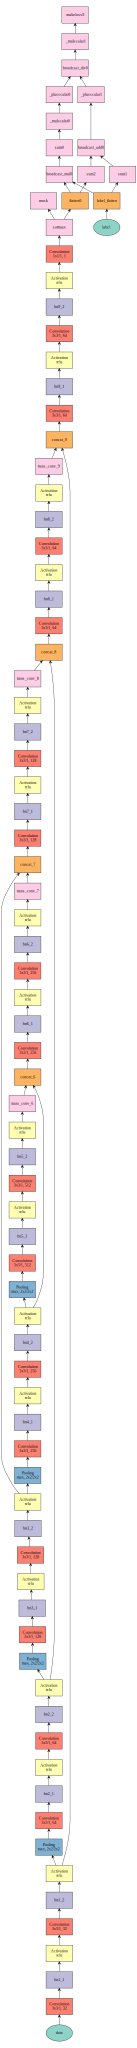

In [25]:
sym = build_unet()
mx.viz.plot_network(sym)

### Train Model

I have trained this model on a P3.8xlarge instance. You will likely need to reduce the batch size to suit the GPU instance you're using.

In [26]:
batch_size = 320
train_iter = mx.io.NDArrayIter(data = train_X_crops, label=train_Y_crops, batch_size=batch_size, shuffle=True)
validation_iter = mx.io.NDArrayIter(data = validation_X_crops, label=validation_Y_crops, batch_size=batch_size, shuffle=False)
data_shape = (batch_size,) + train_X_crops.shape[1:]
label_shape = (batch_size,) + train_Y_crops.shape[1:]

Again, change the variable below to the configuration for your given instance.

In [27]:
NUM_GPUS = 8
ctx = [mx.gpu(i) for i in range(NUM_GPUS)]
# ctx = mx.gpu()

Next, we initialize the model weights and optimizer.

In [28]:
net = mx.mod.Module(sym, context=ctx, data_names=('data',), label_names=('label',))
net.bind(data_shapes=[['data', data_shape]], label_shapes=[['label', label_shape]])

learning_rate = 1E-3
beta1 = 0.9
beta2 = 0.99

net.init_params(mx.initializer.Xavier(magnitude=6))
net.init_optimizer(optimizer = 'adam', 
                           optimizer_params=(
                               ('learning_rate', learning_rate),
                               ('beta1', beta1),
                               ('beta2', beta2)
                          ))

The training loop is manually defined here, saving the model that performs best on the validation set:

In [32]:
start = time.time()
epochs = 100
burn_in = -1

smoothing_constant = .01
curr_losses = []
moving_losses = []
i = 0
best_val_loss = np.inf
for e in range(epochs):
    while True:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        net.forward_backward(batch)
        loss = net.get_outputs()[0]
        net.update()
        curr_loss = F.mean(loss).asscalar()
        curr_losses.append(curr_loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        moving_losses.append(moving_loss)
        i += 1
    val_losses = []
    for batch in validation_iter:
        net.forward(batch)
        loss = net.get_outputs()[0]
        val_losses.append(F.mean(loss).asscalar())
    validation_iter.reset()
    # early stopping
    val_loss = np.mean(val_losses)
    if e > burn_in and val_loss < best_val_loss:
        best_val_loss = val_loss
        net.save_checkpoint('best_net', 0)
        print("Best model at Epoch %i" %(e+1))
    print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+1, moving_loss, val_loss))
end = time.time()

Best model at Epoch 1
Epoch 1: Moving Training Loss -0.18335, Validation Loss -0.45898
Best model at Epoch 2
Epoch 2: Moving Training Loss -0.28179, Validation Loss -0.56276
Best model at Epoch 3
Epoch 3: Moving Training Loss -0.37753, Validation Loss -0.64047
Best model at Epoch 4
Epoch 4: Moving Training Loss -0.46429, Validation Loss -0.69026
Best model at Epoch 5
Epoch 5: Moving Training Loss -0.53852, Validation Loss -0.72145
Best model at Epoch 6
Epoch 6: Moving Training Loss -0.59970, Validation Loss -0.73830
Best model at Epoch 7
Epoch 7: Moving Training Loss -0.64923, Validation Loss -0.75572
Best model at Epoch 8
Epoch 8: Moving Training Loss -0.68906, Validation Loss -0.75943
Best model at Epoch 9
Epoch 9: Moving Training Loss -0.72161, Validation Loss -0.76059
Best model at Epoch 10
Epoch 10: Moving Training Loss -0.74712, Validation Loss -0.78449
Best model at Epoch 11
Epoch 11: Moving Training Loss -0.76731, Validation Loss -0.79126
Epoch 12: Moving Training Loss -0.78362

We can see the model trains as expected.

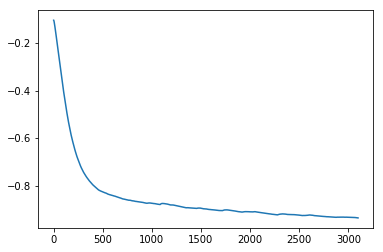

In [33]:
plt.plot(moving_losses)

In [48]:
def post_process_mask(label, p=0.5):
    return (np.where(label > p, 1, 0)).astype('uint8')

In [35]:
net.load_params('best_net-0000.params')

In [36]:
validation_iter.reset()

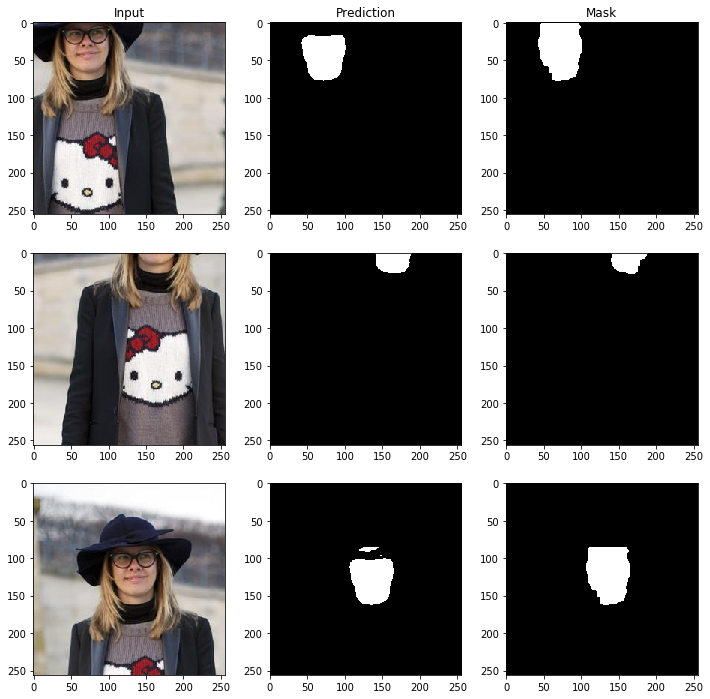

In [38]:
batch = next(validation_iter)
data = batch.data[0].asnumpy()
label = batch.label[0].asnumpy()
net.forward(batch)
output = net.get_outputs()[1].asnumpy()

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(331)
plt.title('Input')
plt.imshow(np.transpose(data[0], (1,2,0)).astype(np.uint8))
plt.subplot(332)
plt.title('Prediction')
plt.imshow(post_process_mask(output[0][0]), cmap=plt.cm.gray)
plt.subplot(333)
plt.title('Mask')
plt.imshow(label[0][0], cmap=plt.cm.gray)
plt.subplot(334)
plt.imshow(np.transpose(data[1], (1,2,0)).astype(np.uint8))
plt.subplot(335)
plt.imshow(post_process_mask(output[1][0]), cmap=plt.cm.gray)
plt.subplot(336)
plt.imshow(label[1][0], cmap=plt.cm.gray)
plt.subplot(337)
plt.imshow(np.transpose(data[2], (1,2,0)).astype(np.uint8))
plt.subplot(338)
plt.imshow(post_process_mask(output[2][0]), cmap=plt.cm.gray)
plt.subplot(339)
plt.imshow(label[2][0], cmap=plt.cm.gray)

## Gluon

Next, we define the model and training loop for the gluon interface. Unlike MXNet Symbolic API, Gluon is an imperative interface that let's you train your models using the NDArray API on the fly. This is advantageous in a model like UNet, which uses concatenations (skip connections) across branches for better training. Such an architecture can be onerous to define in a symbolic manner, but simple imperatively.

In [5]:
from mxnet import nd, autograd
from mxnet import gluon
from mxnet.gluon import nn, HybridBlock
from mxnet import autograd

In [6]:
def build_conv_block(num_filter, kernel, pad):
    net = nn.HybridSequential()
    net.add(nn.Conv2D(channels=num_filter, kernel_size=kernel, padding=pad))
    net.add(nn.BatchNorm())
    net.add(nn.Activation('relu'))
    return net

def build_down_block(num_filter, kernel, pad, first_layer=False, ctx=mx.cpu()):
    net = nn.HybridSequential()
    with net.name_scope():
        if not first_layer:
            net.add(nn.MaxPool2D(pool_size=(2,2)))
        net.add(build_conv_block(num_filter, kernel, pad))
        net.add(build_conv_block(num_filter, kernel, pad))
    net.collect_params().initialize(mx.init.Xavier(magnitude=6), ctx=ctx)
    net.hybridize()
    return net

def build_bottle_neck(input_num_filter, output_num_filter, kernel, pad, ctx=mx.cpu()):
    net = nn.HybridSequential()
    with net.name_scope():
        net.add(nn.MaxPool2D(pool_size=(2,2)))
        net.add(build_conv_block(input_num_filter, kernel, pad))
        net.add(build_conv_block(input_num_filter, kernel, pad))
        net.add(nn.Conv2DTranspose(output_num_filter, kernel_size=(2,2), strides=(2,2), use_bias=False, in_channels=input_num_filter))
    net.collect_params().initialize(mx.init.Xavier(magnitude=6), ctx=ctx)
    net.hybridize()
    return net


def build_up_block(input_num_filter, output_num_filter, kernel, pad, last_layer=False, ctx=mx.cpu()):
    net = nn.HybridSequential()
    with net.name_scope():
        net.add(build_conv_block(input_num_filter, kernel, pad))
        net.add(build_conv_block(input_num_filter, kernel, pad))
        if not last_layer:
            net.add(nn.Conv2DTranspose(output_num_filter, kernel_size=(2,2), strides=(2,2), use_bias=False))
        else:
            net.add(nn.Conv2D(1, kernel_size=(1,1)))
            net.add(nn.Activation('sigmoid'))
    net.collect_params().initialize(mx.init.Xavier(magnitude=6), ctx=ctx)
    net.hybridize()
    return net

Having defined our constructors, we can pass the architecture parameters and construct UNet in Gluon piece-wise.

In [7]:
down_params = [
    [32, (3,3), (1,1), True],
    [64, (3,3), (1,1), False],
    [128, (3,3), (1,1), False],
    [256, (3,3), (1,1), False],
]
up_params = [
    [256, 128, (3,3), (1,1), False],
    [128, 64, (3,3), (1,1), False],
    [64, 32, (3,3), (1,1), False],
    [32, 1, (3,3), (1,1), True]
            ]
ctx = [mx.gpu(i) for i in range(8)]
# ctx = mx.gpu()
down_branch = [build_down_block(p[0], p[1], p[2], p[3], ctx) for p in down_params]
bottleneck = build_bottle_neck(512, 256, (3,3), (1,1), ctx)
up_branch = [build_up_block(p[0], p[1], p[2], p[3], p[4], ctx) for p in up_params]

Next, we need to collect all the parameters and pass them to one global trainer that updates the parameter given the selected optimization algorithm.

In [8]:
learning_rate = 1E-3
beta1 = 0.9
beta2 = 0.99

all_params = []
for n in down_branch + [bottleneck] + up_branch:
    all_params += n.collect_params().values()

trainer = gluon.Trainer(all_params, 'adam', {'learning_rate': learning_rate,'beta1': beta1,'beta2': beta2})

def dice_coef_loss(y_true, y_pred):
    intersection = F.sum(F.broadcast_mul(y_true, y_pred), axis=1, )
    return -F.broadcast_div((2. * intersection + 1.),(F.broadcast_add(F.sum(y_true, axis=1), F.sum(y_pred, axis=1)) + 1.))

Again, you may need to change the batch size given your instance type.

In [9]:
batch_size = 320
train_iter = mx.io.NDArrayIter(data = train_X_crops, label=train_Y_crops, batch_size=batch_size, shuffle=True)
validation_iter = mx.io.NDArrayIter(data = validation_X_crops, label=validation_Y_crops, batch_size=batch_size, shuffle=False)

The commented out code demonstrates how you would define the training loop if you were training on a single GPU.

In [10]:
epochs = 10
burn_in = -1

smoothing_constant = .01
curr_losses = []
moving_losses = []
i = 0
best_val_loss = np.inf
for e in range(epochs):
    for batch in train_iter:
        d = batch.data[0]
        l = batch.label[0]
        data = gluon.utils.split_and_load(d, ctx)
        label = gluon.utils.split_and_load(l, ctx)
#         data = d.as_in_context(ctx)
#         label = l.as_in_context(ctx)
        with autograd.record():
            down_feature_1 = [down_branch[0](d) for d in data]
#             down_feature_1 = down_branch[0](data)
            down_feature_2 = [down_branch[1](d) for d in down_feature_1]
#             down_feature_2 = down_branch[1](down_feature_1)
            down_feature_3 = [down_branch[2](d) for d in down_feature_2]
#             down_feature_3 = down_branch[2](down_feature_2)
            down_feature_4 = [down_branch[3](d) for d in down_feature_3]
#             down_feature_4 = down_branch[3](down_feature_3)
            bottle = [bottleneck(d) for d in down_feature_4]
#             bottle = bottleneck(down_feature_4)
            concat_1 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_4, bottle)]
#             concat_1 = F.concat(down_feature_4, bottle, dim=1)
            up_feature_1 = [up_branch[0](c) for c in concat_1]
#             up_feature_1 = up_branch[0](concat_1)
            concat_2 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_3, up_feature_1)]
#             concat_2 = F.concat(down_feature_3, up_feature_1, dim=1)
            up_feature_2 = [up_branch[1](c) for c in concat_2]
#             up_feature_2 = up_branch[1](concat_2)
            concat_3 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_2, up_feature_2)]
#             concat_3 = F.concat(down_feature_2, up_feature_2, dim=1)
            up_feature_3 = [up_branch[2](c) for c in concat_3]
#             up_feature_3 = up_branch[2](concat_3)
            concat_4 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_1, up_feature_3)]
#             concat_4 = F.concat(down_feature_1, up_feature_3, dim=1)
            output = [up_branch[3](c) for c in concat_4]
#             output = up_branch[3](concat_4)
            loss = [dice_coef_loss(F.flatten(l), F.flatten(o)) for l, o in zip (label, output)]
        for l in loss:
            l.backward()
        trainer.step(len(data)*data[0].shape[0])
        curr_loss = np.mean(np.stack([l.asnumpy() for l in loss]))
        curr_losses.append(curr_loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        moving_losses.append(moving_loss)
        i += 1
    train_iter.reset()
    val_losses = []
    for batch in validation_iter:
        d = batch.data[0]
        l = batch.label[0]
        data = gluon.utils.split_and_load(d, ctx)
        label = gluon.utils.split_and_load(l, ctx)
#         data = d.as_in_context(ctx)
#         label = l.as_in_context(ctx)
        down_feature_1 = [down_branch[0](d) for d in data]
#             down_feature_1 = down_branch[0](data)
        down_feature_2 = [down_branch[1](d) for d in down_feature_1]
#             down_feature_2 = down_branch[1](down_feature_1)
        down_feature_3 = [down_branch[2](d) for d in down_feature_2]
#             down_feature_3 = down_branch[2](down_feature_2)
        down_feature_4 = [down_branch[3](d) for d in down_feature_3]
#             down_feature_4 = down_branch[3](down_feature_3)
        bottle = [bottleneck(d) for d in down_feature_4]
#             bottle = bottleneck(down_feature_4)
        concat_1 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_4, bottle)]
#             concat_1 = F.concat(down_feature_4, bottle, dim=1)
        up_feature_1 = [up_branch[0](c) for c in concat_1]
#             up_feature_1 = up_branch[0](concat_1)
        concat_2 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_3, up_feature_1)]
#             concat_2 = F.concat(down_feature_3, up_feature_1, dim=1)
        up_feature_2 = [up_branch[1](c) for c in concat_2]
#             up_feature_2 = up_branch[1](concat_2)
        concat_3 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_2, up_feature_2)]
#             concat_3 = F.concat(down_feature_2, up_feature_2, dim=1)
        up_feature_3 = [up_branch[2](c) for c in concat_3]
#             up_feature_3 = up_branch[2](concat_3)
        concat_4 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_1, up_feature_3)]
#             concat_4 = F.concat(down_feature_1, up_feature_3, dim=1)
        output = [up_branch[3](c) for c in concat_4]
#             output = up_branch[3](concat_4)
        loss = [dice_coef_loss(F.flatten(l), F.flatten(o)) for l, o in zip (label, output)]
        val_losses.append(np.mean(np.stack([l.asnumpy() for l in loss])))
    validation_iter.reset()
    # early stopping
    val_loss = np.mean(val_losses)
    if e > burn_in and val_loss < best_val_loss:
        best_val_loss = val_loss
        for j, n in enumerate(down_branch + [bottleneck] + up_branch):
            n.save_params('gluon_net_%i.params'%j)
        print("Best model at Epoch %i" %(e+1))
    print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+1, moving_loss, val_loss))

Best model at Epoch 1
Epoch 1: Moving Training Loss -0.18239, Validation Loss -0.31165
Best model at Epoch 2
Epoch 2: Moving Training Loss -0.28432, Validation Loss -0.59207
Best model at Epoch 3
Epoch 3: Moving Training Loss -0.38018, Validation Loss -0.67079
Best model at Epoch 4
Epoch 4: Moving Training Loss -0.46504, Validation Loss -0.70157
Best model at Epoch 5
Epoch 5: Moving Training Loss -0.53624, Validation Loss -0.72124
Epoch 6: Moving Training Loss -0.59516, Validation Loss -0.71196
Best model at Epoch 7
Epoch 7: Moving Training Loss -0.64510, Validation Loss -0.76654
Best model at Epoch 8
Epoch 8: Moving Training Loss -0.68422, Validation Loss -0.78433
Epoch 9: Moving Training Loss -0.71475, Validation Loss -0.76524
Best model at Epoch 10
Epoch 10: Moving Training Loss -0.74040, Validation Loss -0.78872


We can load each parameter set manually for the best model:

In [32]:
for j, n in enumerate(down_branch + [bottleneck] + up_branch):
    n.load_params('gluon_net_%i.params'%j, ctx=ctx)

In [13]:
validation_iter.reset()

We achieve the same results as in the MXNet Symbolic case.

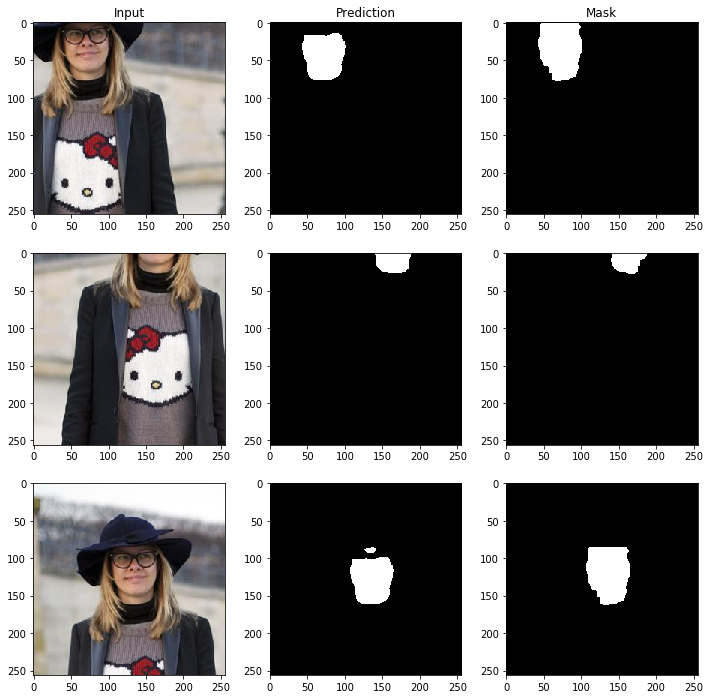

In [11]:
batch = next(validation_iter)
x = batch.data[0].asnumpy()
y = batch.label[0].asnumpy()
data = gluon.utils.split_and_load(batch.data[0], ctx)
down_feature_1 = [down_branch[0](d) for d in data]
#             down_feature_1 = down_branch[0](data)
down_feature_2 = [down_branch[1](d) for d in down_feature_1]
#             down_feature_2 = down_branch[1](down_feature_1)
down_feature_3 = [down_branch[2](d) for d in down_feature_2]
#             down_feature_3 = down_branch[2](down_feature_2)
down_feature_4 = [down_branch[3](d) for d in down_feature_3]
#             down_feature_4 = down_branch[3](down_feature_3)
bottle = [bottleneck(d) for d in down_feature_4]
#             bottle = bottleneck(down_feature_4)
concat_1 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_4, bottle)]
#             concat_1 = F.concat(down_feature_4, bottle, dim=1)
up_feature_1 = [up_branch[0](c) for c in concat_1]
#             up_feature_1 = up_branch[0](concat_1)
concat_2 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_3, up_feature_1)]
#             concat_2 = F.concat(down_feature_3, up_feature_1, dim=1)
up_feature_2 = [up_branch[1](c) for c in concat_2]
#             up_feature_2 = up_branch[1](concat_2)
concat_3 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_2, up_feature_2)]
#             concat_3 = F.concat(down_feature_2, up_feature_2, dim=1)
up_feature_3 = [up_branch[2](c) for c in concat_3]
#             up_feature_3 = up_branch[2](concat_3)
concat_4 = [F.concat(dl, dr, dim=1) for dl, dr in zip(down_feature_1, up_feature_3)]
#             concat_4 = F.concat(down_feature_1, up_feature_3, dim=1)
output = np.concatenate([up_branch[3](c).asnumpy() for c in concat_4])
#             output = up_branch[3](concat_4)

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(331)
plt.title('Input')
plt.imshow(np.transpose(x[0], (1,2,0)).astype(np.uint8))
plt.subplot(332)
plt.title('Prediction')
plt.imshow(post_process_mask(output[0][0]), cmap=plt.cm.gray)
plt.subplot(333)
plt.title('Mask')
plt.imshow(y[0][0], cmap=plt.cm.gray)
plt.subplot(334)
plt.imshow(np.transpose(x[1], (1,2,0)).astype(np.uint8))
plt.subplot(335)
plt.imshow(post_process_mask(output[1][0]), cmap=plt.cm.gray)
plt.subplot(336)
plt.imshow(y[1][0], cmap=plt.cm.gray)
plt.subplot(337)
plt.imshow(np.transpose(x[2], (1,2,0)).astype(np.uint8))
plt.subplot(338)
plt.imshow(post_process_mask(output[2][0]), cmap=plt.cm.gray)
plt.subplot(339)
plt.imshow(y[2][0], cmap=plt.cm.gray)

## SageMaker

Now that we've prototyped this model, we can define a training job in SageMaker to do training at scale.

In [28]:
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from sagemaker import get_execution_role

In [25]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

We need to upload the data to S3 so the instances launched for the training job can pull the data down.

In [26]:
inputs = sagemaker_session.upload_data(path='/dev/shm/clothing-co-parsing/segmentation_data', key_prefix='sagemaker_data')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208


Finally, we create the MXNet SageMaker model estimator using the **Bring your own script** paradigm. We've defined a script, <tt>segmentation.py</tt>, that runs the training loop for UNet in MXNet Symbolic. To do this, we follow the conventions defined for the SageMaker Python SDK [here](https://github.com/aws/sagemaker-python-sdk).

In [36]:
#SAGEMAKER NOTEBOOK CODE
sagemaker_net = MXNet("segmentation.py", 
                  role=role, 
                  train_instance_count=1, 
                  train_instance_type="ml.p2.xlarge",
                  sagemaker_session=sagemaker_session,
                  hyperparameters={
                                 'data_shape': (3, 256, 256),
                                 'batch_size': 32, 
                                 'epochs': 10, 
                                 'learning_rate': 1E-3, 
                                 'num_gpus': 1,
                                  })

sagemaker_net.fit(inputs)

INFO:sagemaker:Creating training-job with name: deeplens-skin-segmentation-training-job


..................................................................................................
executing startup script (first run)
2018-02-26 00:05:34,063 INFO - root - running container entrypoint
2018-02-26 00:05:34,063 INFO - root - starting train task
2018-02-26 00:05:35,582 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'segmentation.py', u'num_gpus': 1, u'data_shape': [3,

In [32]:
np.where(np.array([0,1,2]) > 0, 255, 0) 

array([  0, 255, 255])

Once the training is complete, we can launch an endpoint server that serves inference with our trained model.

In [37]:
sagemaker_predictor = sagemaker_net.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: deeplens-skin-segmentation-training-job
INFO:sagemaker:Creating endpoint with name deeplens-skin-segmentation-training-job


----------------------------------------------------------------------------------------------------------------!

In [41]:
test_iter = mx.io.NDArrayIter(data = validation_X_crops, label=validation_Y_crops, batch_size=1, shuffle=False)

We can send test data to the inference endpoint:

In [43]:
batch = next(test_iter)
data = batch.data[0]
label = batch.label[0]
response = sagemaker_predictor.predict(data.asnumpy().tolist())\
output = np.array(response[0])

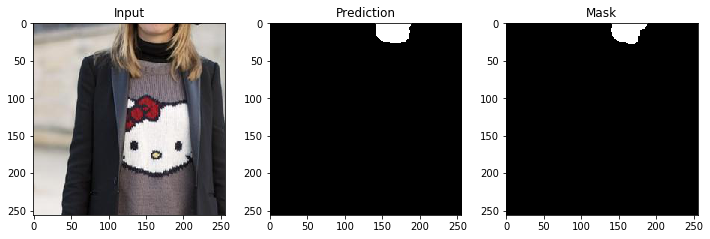

In [50]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(331)
plt.title('Input')
plt.imshow(np.transpose(data.asnumpy()[0], (1,2,0)).astype(np.uint8))
plt.subplot(332)
plt.title('Prediction')
plt.imshow(post_process_mask(output[0]), cmap=plt.cm.gray)
plt.subplot(333)
plt.title('Mask')
plt.imshow(label[0][0].asnumpy(), cmap=plt.cm.gray)

Don't forget to delete your endpoint when you're done with it.

In [ ]:
sagemaker_net.delete_endpoint()